## Enhanced Fraud Detection System Model for E-Commerce and Banking Transactions Using Machine Learning
## Overview
This challenge focuses on building robust machine learning models for fraud detection in e-commerce and banking transactions. The project will involve analyzing, preprocessing, and integrating transaction data from both domains, engineering fraud-related features, and training multiple machine learning and deep learning models to detect fraudulent activity. The challenge also includes using geolocation and transaction pattern analysis to improve detection accuracy.

Participants will develop real-time fraud detection systems, ensuring efficiency and scalability in deployment. The project aims to deliver a fully operational fraud detection pipeline that includes model explainability, API deployment, and interactive dashboards.

## Objective
The primary objective of this challenge is to improve the detection of fraud cases in e-commerce and bank credit transactions by:

- Developing machine learning models to identify fraudulent patterns in both e-commerce and credit card transactions.
- Implementing geolocation analysis using IP address mappings and transaction pattern recognition.
- Enhancing model explainability through tools like SHAP and LIME for transparency in fraud detection.
- Deploying models in real-time using Flask, Docker, and developing APIs for serving fraud predictions.
- Creating an interactive dashboard with Dash to visualize fraud trends, fraud hotspots, and summary insights from transaction data.

## 1. Data Colllection

### Import Necessary Library

In [23]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report

### Load Dataset

In [24]:
fraud_data = pd.read_csv("../data/Fraud_cleaned_Data.csv")
fraud_data.head()

,Unnamed: 0,purchase_value,age,ip_address,class,frequency,velocity,hour_of_day,day_of_week,time_diff,signup_hour,signup_day_of_week,purchase_day_of_week,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
0,0,0.172414,0.362069,0.170603,0,1,34,0.086957,0.833333,4506682.0,22,1,5,False,True,False,False,False,False,True
1,1,0.048276,0.603448,0.081554,0,1,16,0.043478,0.000000,17944.0,20,6,0,False,False,False,False,False,False,False
2,2,0.041379,0.603448,0.610371,1,1,15,0.782609,0.500000,1.0,18,3,3,False,True,False,False,True,False,True
3,3,0.241379,0.396552,0.894219,0,1,44,0.565217,0.000000,492085.0,21,1,0,False,True,False,False,False,True,True
4,4,0.206897,0.465517,0.096752,0,1,39,0.782609,0.333333,4361461.0,7,1,2,False,False,False,False,False,True,True


In [25]:
fraud_data.drop(columns=['Unnamed: 0'], inplace=True)
fraud_data.head()

,purchase_value,age,ip_address,class,frequency,velocity,hour_of_day,day_of_week,time_diff,signup_hour,signup_day_of_week,purchase_day_of_week,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
0,0.172414,0.362069,0.170603,0,1,34,0.086957,0.833333,4506682.0,22,1,5,False,True,False,False,False,False,True
1,0.048276,0.603448,0.081554,0,1,16,0.043478,0.000000,17944.0,20,6,0,False,False,False,False,False,False,False
2,0.041379,0.603448,0.610371,1,1,15,0.782609,0.500000,1.0,18,3,3,False,True,False,False,True,False,True
3,0.241379,0.396552,0.894219,0,1,44,0.565217,0.000000,492085.0,21,1,0,False,True,False,False,False,True,True
4,0.206897,0.465517,0.096752,0,1,39,0.782609,0.333333,4361461.0,7,1,2,False,False,False,False,False,True,True


In [26]:
creditcard_data = pd.read_csv("../data/creditcard.csv")
creditcard_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. Train test split

#### 2.1 Separet dependant and independant feature

In [27]:
# For Credit Card Data
X_creditcard = creditcard_data.drop(columns=['Class'])  # independant Features
y_creditcard = creditcard_data['Class']                   # Target variable

# For Fraud Data
X_fraud = fraud_data.drop(columns=['class'])  # independant Features
y_fraud = fraud_data['class']      # Target variable


### 2.2 trian test split by 80/20 percent

In [28]:
# Train-test split for Credit Card Data
X_train_creditcard, X_test_creditcard, y_train_creditcard, y_test_creditcard = train_test_split(
    X_creditcard, y_creditcard, test_size=0.2, random_state=42, stratify=y_creditcard
)

# Train-test split for Fraud Data
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

In [29]:
print(y_train_fraud.value_counts())
print(y_train_creditcard.value_counts())

class
0    109568
1     11321
Name: count, dtype: int64
Class
0    227451
1       394
Name: count, dtype: int64


from the above the two dataset is highly imbalanced. we have used SMOTE to handle imbalancing natures of the dataset to maintain model biasing 

### 2.3 Class balancing (Data resampling)

In [30]:
# Apply SMOTE-Tomek Link for Credit Card Data
from imblearn.combine import SMOTETomek
smote_tomek_creditcard = SMOTETomek(random_state=42)
X_train_creditcard_resampled, y_train_creditcard_resampled = smote_tomek_creditcard.fit_resample(X_train_creditcard, y_train_creditcard)

# Apply SMOTE-Tomik for Fraud Data
smote_tomek_fraud = SMOTETomek(random_state=42)
X_train_fraud_resampled, y_train_fraud_resampled = smote_tomek_fraud.fit_resample(X_train_fraud, y_train_fraud)


# 3. Model Building and Trianing

### 3.1 Model Selection and Trianing

In [31]:
# Fit XGBoost Model
from xgboost import XGBClassifier
xgb_creditcard = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_creditcard.fit(X_train_creditcard_resampled, y_train_creditcard_resampled)

xgb_fraud = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_fraud.fit(X_train_fraud_resampled, y_train_fraud_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## 3.2 Predictions

In [32]:
# Predictions
y_pred_creditcard = xgb_creditcard.predict(X_test_creditcard)
y_pred_fraud = xgb_fraud.predict(X_test_fraud)

In [33]:
# Evaluation Metrics
accuracy_creditcard = accuracy_score(y_test_creditcard, y_pred_creditcard)
precision_creditcard = precision_score(y_test_creditcard, y_pred_creditcard, average='weighted')
recall_creditcard = recall_score(y_test_creditcard, y_pred_creditcard, average='weighted')
f1_creditcard = f1_score(y_test_creditcard, y_pred_creditcard, average='weighted')

accuracy_fraud = accuracy_score(y_test_fraud, y_pred_fraud)
precision_fraud = precision_score(y_test_fraud, y_pred_fraud, average='weighted')
recall_fraud = recall_score(y_test_fraud, y_pred_fraud, average='weighted')
f1_fraud = f1_score(y_test_fraud, y_pred_fraud, average='weighted')

In [34]:
# Classification Reports
classification_report_creditcard = classification_report(y_test_creditcard, y_pred_creditcard)
print("Classification Report for Credit Card Data:\n", classification_report_creditcard)

classification_report_fraud = classification_report(y_test_fraud, y_pred_fraud)
print("Classification Report for Fraud Data:\n", classification_report_fraud)

Classification Report for Credit Card Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.86      0.84        98

    accuracy                           1.00     56962
   macro avg       0.91      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Classification Report for Fraud Data:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.97      0.53      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.96      0.76      0.83     30223
weighted avg       0.96      0.95      0.95     30223



In [35]:
# Display Metrics
print("Credit Card Data Metrics:")
print(f"Accuracy: {accuracy_creditcard:.4f}")
print(f"Weighted Precision: {precision_creditcard:.4f}")
print(f"Weighted Recall: {recall_creditcard:.4f}")
print(f"Weighted F1 Score: {f1_creditcard:.4f}")

print("\nFraud Data Metrics:")
print(f"Accuracy: {accuracy_fraud:.4f}")
print(f"Weighted Precision: {precision_fraud:.4f}")
print(f"Weighted Recall: {recall_fraud:.4f}")
print(f"Weighted F1 Score: {f1_fraud:.4f}")

Credit Card Data Metrics:
Accuracy: 0.9994
Weighted Precision: 0.9994
Weighted Recall: 0.9994
Weighted F1 Score: 0.9994

Fraud Data Metrics:
Accuracy: 0.9544
Weighted Precision: 0.9552
Weighted Recall: 0.9544
Weighted F1 Score: 0.9482


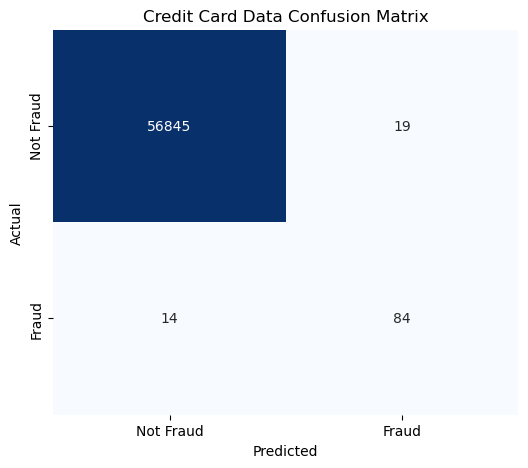

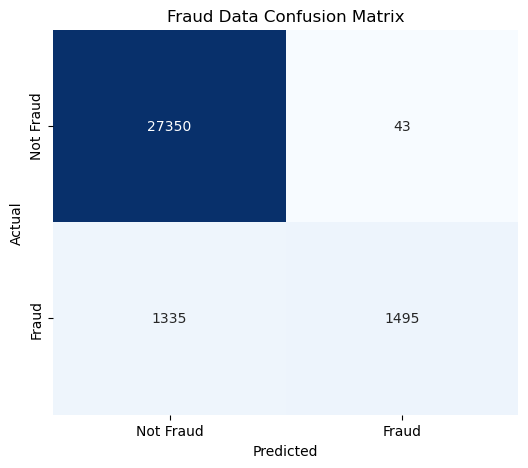

In [36]:
# Confusion Matrix and Plotting
cm_creditcard = confusion_matrix(y_test_creditcard, y_pred_creditcard)
cm_fraud = confusion_matrix(y_test_fraud, y_pred_fraud)

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot for Credit Card Data
plot_confusion_matrix(cm_creditcard, title='Credit Card Data Confusion Matrix')

# Plot for Fraud Data
plot_confusion_matrix(cm_fraud, title='Fraud Data Confusion Matrix')

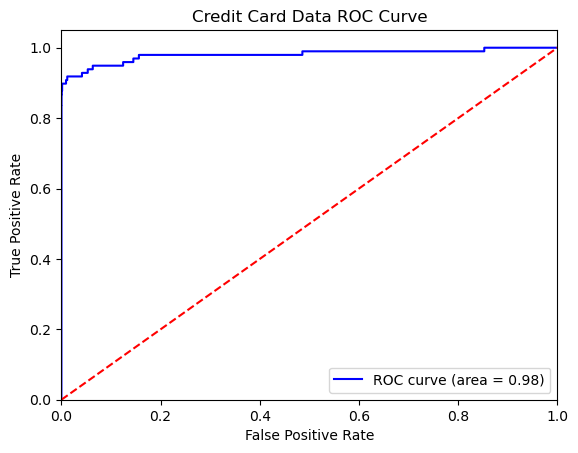

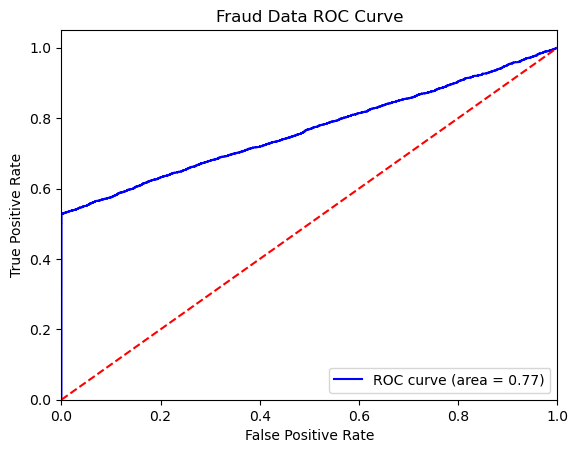

In [37]:
# ROC Curve and AUC
def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Get predicted probabilities for ROC
y_scores_creditcard = xgb_creditcard.predict_proba(X_test_creditcard)[:, 1]
y_scores_fraud = xgb_fraud.predict_proba(X_test_fraud)[:, 1]

# Plot ROC Curve for Credit Card Data
plot_roc_curve(y_test_creditcard, y_scores_creditcard, title='Credit Card Data ROC Curve')

# Plot ROC Curve for Fraud Data
plot_roc_curve(y_test_fraud, y_scores_fraud, title='Fraud Data ROC Curve')

<Figure size 1000x600 with 0 Axes>

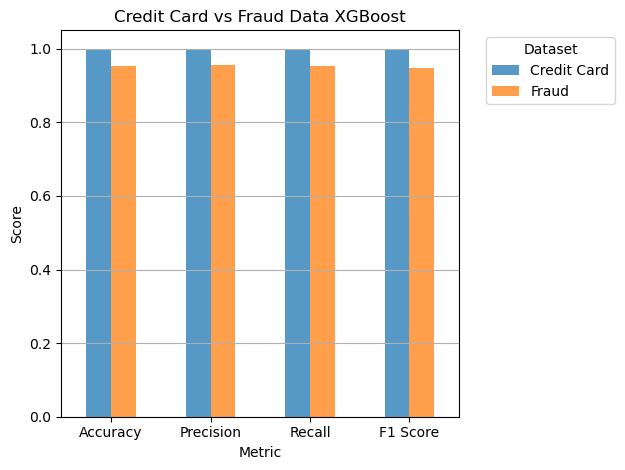

In [38]:
# Model Comparison Plot
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Credit Card': [accuracy_creditcard, precision_creditcard, recall_creditcard, f1_creditcard],
    'Fraud': [accuracy_fraud, precision_fraud, recall_fraud, f1_fraud]
}

metrics_df = pd.DataFrame(metrics)

# Plotting
plt.figure(figsize=(10, 6))
ax = metrics_df.set_index('Metric').plot(kind='bar', alpha=0.75)

# Set the title and labels
plt.title('Credit Card vs Fraud Data XGBoost')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.grid(axis='y')

# Adjusting the legend position
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make space for the legend
plt.tight_layout()

plt.show()

In [39]:
import joblib
joblib.dump(xgb_fraud, 'model/XGBoost_model_fraud.pkl')
print("Models saved as .pkl files.")

Models saved as .pkl files.


In [40]:
import joblib
joblib.dump(xgb_creditcard, 'model/XGBoost_model_creditcard.pkl')
print("Models saved as .pkl files.")

Models saved as .pkl files.
